# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [2]:
import os, sys, random, math

import imageio
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from scipy.ndimage.morphology import binary_fill_holes
from skimage.transform import resize
from skimage.io import imread, imshow, imread_collection, concatenate_images
from pathlib import Path
import cv2
%matplotlib inline

In [3]:
from mrcnn import utils, visualize, model as modellib
from mrcnn.config import Config

Using TensorFlow backend.


In [4]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join('../models')

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(MODEL_DIR, 'mask_rcnn_coco.h5')

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [5]:
class CocoConfig(Config):
    """Configuration for training on MS COCO.
    Derives from the base Config class and overrides values specific
    to the COCO dataset.
    """
    # Give the configuration a recognizable name
    NAME = 'coco'
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    # Number of classes (including background)
    NUM_CLASSES = 1 + 80  # COCO has 80 classes

config = CocoConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Create Model and Load Trained Weights

In [6]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


## Class Names


In [7]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

## Custom class wrapper for clomask images

In [8]:
class ClomaskDataset(object):
    def __init__(self, folder_desc, image_id):
        self.IMAGE_DIR = Path('../data/%s'%folder_desc)
        self.IMAGE_PATH = os.path.join(self.IMAGE_DIR, 'IMG_' + image_id + '.JPG')
        self.IMAGE_ID = image_id
        self.DESC = folder_desc
        self.CLASS_ID = 40

    def load_image(self):
        img = cv2.imread(self.IMAGE_PATH)
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
        return img
    
    def load_mask(self):
        path = os.path.join(self.IMAGE_DIR, 'masks')

        complete_mask = []
        for mask_file in next(os.walk(path))[2]:
            if 'png' in mask_file:
                single_mask = cv2.imread(os.path.join(path + os.path.sep + mask_file), 0)
                if len(single_mask.shape) > 2:
                    single_mask = single_mask[:,:,0]
                    print(single_mask.shape)

                # binary_holes filling
                single_mask = binary_fill_holes(single_mask).astype(np.int32)
                # check for mask to be atleast 1 pixel
                if np.sum(single_mask) >= 1:
                    complete_mask.append(np.squeeze(single_mask))
        complete_mask = np.stack(complete_mask, axis=-1)
        complete_mask = complete_mask.astype(np.uint8)
        
        class_ids = np.zeros(complete_mask.shape[2])
        class_ids[:] = self.CLASS_ID
        class_ids = class_ids.astype(np.int8)
        return complete_mask, class_ids

In [9]:
def eval_single(folder, image_id):
    clomask = ClomaskDataset(folder, image_id)
    image = clomask.load_image()
    result = model.detect([image], verbose=0)[0]

    fig, axes = plt.subplots(1, 2, figsize=(16,9))

    axes[0].imshow(image)
    axes[0].set_title('Original Image')

    visualize.display_instances(image, result['rois'], result['masks'], result['class_ids'], 
                                class_names, result['scores'], ax=axes[1])
    axes[1].set_title('Predicted Mask')

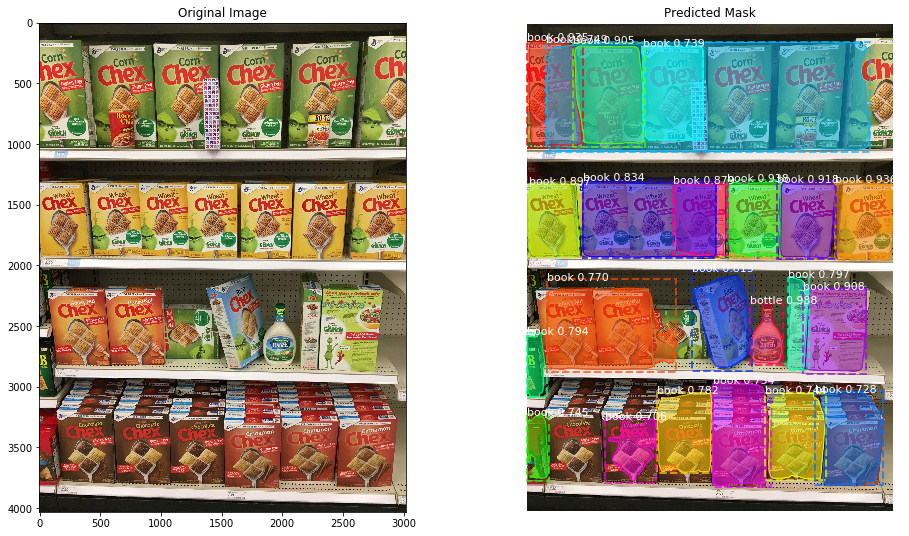

In [35]:
eval_single('box-shelf-eval', '3769')

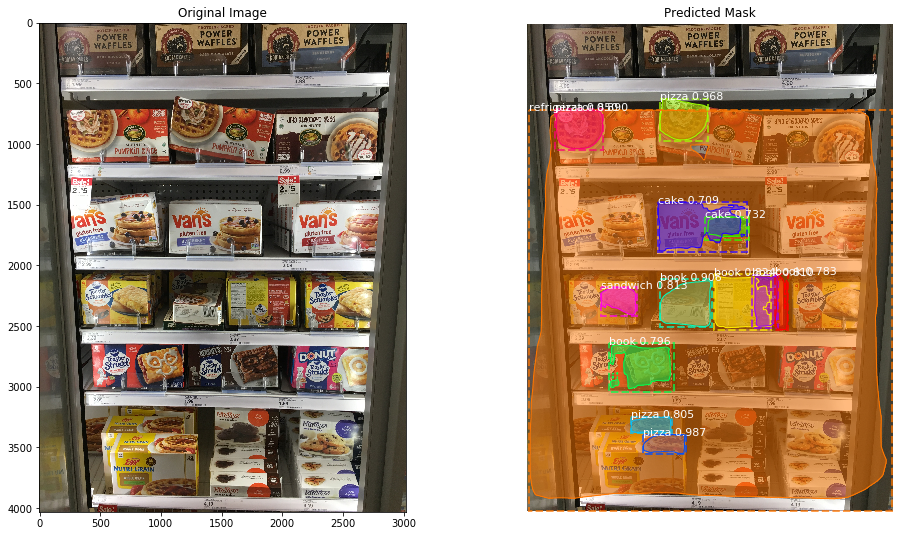

In [37]:
eval_single('box-fridge-eval', '3802')

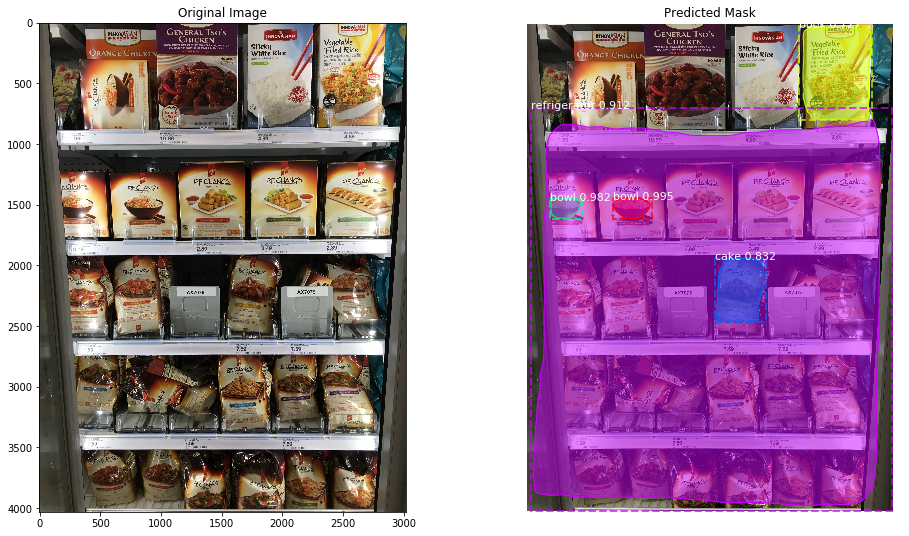

In [38]:
eval_single('box-fridge-eval', '3808')